In [ ]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Definizione Rete Neurale

In [ ]:
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

In [ ]:
## Inizializzazione neuroni

mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

mem2_rec = []
spk1_rec = []
spk2_rec = []

In [ ]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)

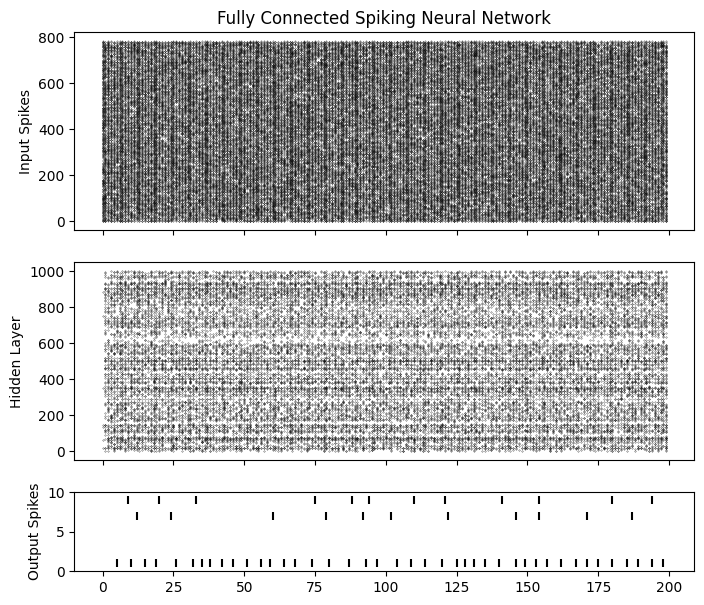

In [ ]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

# Allenare una Rete Neurale Spiking

In [ ]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [ ]:
lif1 = snn.Leaky(beta=0.9)
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [ ]:
# Definizione della classe Model
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Inizializziamo l'architettura della SNN
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Inizializzazione delle variabili di stato
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Lista per i valori finali
        spk2_rec = []
        mem2_rec = []

        # Elaborazione dell'input per tutta l'architettura
        # della rete e per tutti i timesteps
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
model = Model().to(device)

In [ ]:
# Definiamo la transform che permette di: ridimensionare,
# convertire in grascale, trasformare in tensore e
# normalizzare i valori con media 0 e deviazione standard 1
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Scarichiamo i dataset di train e test
mnist_train = datasets.MNIST(data_path, train=True,
                             download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False,
                            download=True, transform=transform)

# Creiamo i dataloader per poter allenare la rete
train_loader = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size,
                         shuffle=True, drop_last=True)

In [ ]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = model(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [ ]:
train_batch = iter(train_loader)
for data, targets in train_batch:
    data = data.to(device)
    targets = targets.to(device)
    break

In [ ]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Definizione del traninig loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Training per batch
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        spk_rec, mem_rec = model(data.view(batch_size, -1))

        # Inizializzazione della loss e somma per i timestep
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Calcolo del gradiente e aggiornamento dei pesi
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Salvataggio della loss per plot
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            model.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = model(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 60.99
Test Set Loss: 53.30
Train set accuracy for a single minibatch: 45.31%
Test set accuracy for a single minibatch: 35.94%


Epoch 0, Iteration 50
Train Set Loss: 15.29
Test Set Loss: 11.17
Train set accuracy for a single minibatch: 83.59%
Test set accuracy for a single minibatch: 84.38%


Epoch 0, Iteration 100
Train Set Loss: 19.03
Test Set Loss: 13.28
Train set accuracy for a single minibatch: 81.25%
Test set accuracy for a single minibatch: 82.81%


Epoch 0, Iteration 150
Train Set Loss: 9.87
Test Set Loss: 10.42
Train set accuracy for a single minibatch: 82.81%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 200
Train Set Loss: 11.45
Test Set Loss: 7.11
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 250
Train Set Loss: 7.04
Test Set Loss: 10.81
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 87.50%


Epoc

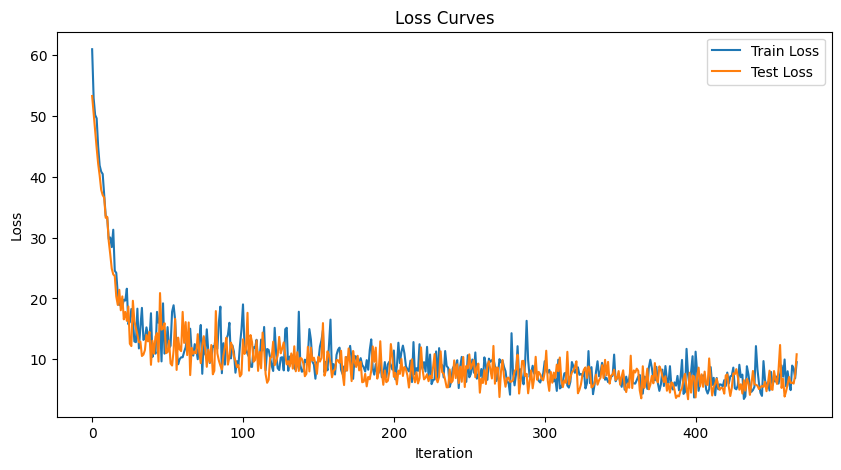

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  model.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = model(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

In [ ]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9233/10000
Test Set Accuracy: 92.33%
